In [50]:
import pandas as pd
import matplotlib.pyplot as plt #导入图像库
from sklearn.ensemble import RandomForestRegressor

# 用随机森林对缺失值预测填充函数
def set_missing(df):
    # 把已有的数值型特征取出来
    process_df = df.ix[:,[5,0,1,2,3,4,6,7,8,9]]
    # 分成已知该特征和未知该特征两部分
    known = process_df[process_df.MonthlyIncome.notnull()].as_matrix()
    unknown = process_df[process_df.MonthlyIncome.isnull()].as_matrix()
    # X为特征属性值
    X = known[:, 1:]
    # y为结果标签值
    y = known[:, 0]
    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=200,max_depth=3,n_jobs=-1)
    rfr.fit(X,y)
    # 用得到的模型进行未知特征值预测
    predicted = rfr.predict(unknown[:, 1:]).round(0)
    print(predicted)
    # 用得到的预测结果填补原缺失数据
    df.loc[(df.MonthlyIncome.isnull()), 'MonthlyIncome'] = predicted
    return df

if __name__ == '__main__':
    #载入数据
    data = pd.read_csv(r'C:\456yang\begin\信用评分模型代码\cs-training.csv')
    #数据集确实和分布情况
    data.describe().to_csv('DataDescribe.csv')#了解数据集的分布情况
    data=set_missing(data)#用随机森林填补比较多的缺失值
    data=data.dropna()#删除比较少的缺失值
    data = data.drop_duplicates()#删除重复项
    data.to_csv('MissingData.csv',index=False)
    data.describe().to_csv('MissingDataDescribe.csv')
    """
    #异常值处理
    #年龄等于0的异常值进行剔除
    data=data[data['age']>0]
    # 箱形图
    data379=data[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse']]
    data379.boxplot()
    data = data[data['NumberOfTime30-59DaysPastDueNotWorse'] < 90]
    data379 = data[['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']]
    #data379.boxplot()
    plt.show()
    #data.to_csv('PretreatmentData.csv')
    """

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


[8311. 1159. 8311. ... 1159. 2554. 2554.]


                       min           max   sum  total      rate       woe  \
Bucket                                                                      
(-0.001, 0.0299]  0.000000      0.029866   690  37500  0.018400 -1.340558   
(0.0299, 0.154]   0.029868      0.154176   745  37500  0.019867 -1.262370   
(0.154, 0.559]    0.154186      0.559044  1888  37500  0.050347 -0.300890   
(0.559, 50708.0]  0.559053  50708.000000  6703  37500  0.178747  1.111413   

                  goodattribute  badattribute  
Bucket                                         
(-0.001, 0.0299]       0.068821      0.262977  
(0.0299, 0.154]        0.074307      0.262584  
(0.154, 0.559]         0.188310      0.254419  
(0.559, 50708.0]       0.668562      0.220019  
                min  max   sum  total      rate       woe  goodattribute  \
Bucket                                                                     
(-0.001, 33.0]    0   33  1940  17085  0.113550  0.581293       0.193497   
(33.0, 40.0]     34  

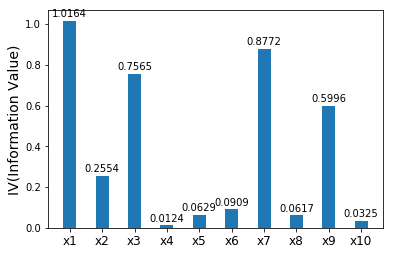

In [56]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
import scipy.stats.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math

# 定义自动分箱函数
def mono_bin(Y, X, n = 20):
    r = 0
    good=Y.sum()
    bad=Y.count()-good
    while np.abs(r) < 1:
        d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, n)})
        d2 = d1.groupby('Bucket', as_index = True)
        r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
        n = n - 1
    d3 = pd.DataFrame(d2.X.min(), columns = ['min'])
    d3['min']=d2.min().X
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().Y
    d3['total'] = d2.count().Y
    d3['rate'] = d2.mean().Y
    d3['woe']=np.log((d3['rate']/(1-d3['rate']))/(good/bad))
    d3['goodattribute']=d3['sum']/good
    d3['badattribute']=(d3['total']-d3['sum'])/bad
    iv=((d3['goodattribute']-d3['badattribute'])*d3['woe']).sum()
    d4 = (d3.sort_values(by = 'min'))
    print("=" * 60)
    print(d4)
    cut=[]
    cut.append(float('-inf'))
    for i in range(1,n+1):
        qua=X.quantile(i/(n+1))
        cut.append(round(qua,4))
    cut.append(float('inf'))
    woe=list(d4['woe'].round(3))
    return d4,iv,cut,woe
#自定义分箱函数
def self_bin(Y,X,cat):
    good=Y.sum()
    bad=Y.count()-good
    d1=pd.DataFrame({'X':X,'Y':Y,'Bucket':pd.cut(X,cat)})
    d2=d1.groupby('Bucket', as_index = True)
    d3 = pd.DataFrame(d2.X.min(), columns=['min'])
    d3['min'] = d2.min().X
    d3['max'] = d2.max().X
    d3['sum'] = d2.sum().Y
    d3['total'] = d2.count().Y
    d3['rate'] = d2.mean().Y
    d3['woe'] = np.log((d3['rate'] / (1 - d3['rate'])) / (good / bad))
    d3['goodattribute'] = d3['sum'] / good
    d3['badattribute'] = (d3['total'] - d3['sum']) / bad
    iv = ((d3['goodattribute'] - d3['badattribute']) * d3['woe']).sum()
    d4 = (d3.sort_values(by='min'))
    print("=" * 60)
    print(d4)
    woe = list(d4['woe'].round(3))
    return d4, iv,woe
#用woe代替
def replace_woe(series,cut,woe):
    list=[]
    i=0
    while i<len(series):
        value=series[i]
        j=len(cut)-2
        m=len(cut)-2
        while j>=0:
            if value>=cut[j]:
                j=-1
            else:
                j -=1
                m -= 1
        list.append(woe[m])
        i += 1
    return list


if __name__ == '__main__':
    data = pd.read_csv(r'C:\456yang\begin\信用评分模型代码\cs-training.csv')
    pinf = float('inf')#正无穷大
    ninf = float('-inf')#负无穷大
    dfx1, ivx1,cutx1,woex1=mono_bin(data.SeriousDlqin2yrs,data.RevolvingUtilizationOfUnsecuredLines,n=10)
    dfx2, ivx2,cutx2,woex2=mono_bin(data.SeriousDlqin2yrs, data.age, n=10)
    dfx4, ivx4,cutx4,woex4 =mono_bin(data.SeriousDlqin2yrs, data.DebtRatio, n=20)
    dfx5, ivx5,cutx5,woex5 =mono_bin(data.SeriousDlqin2yrs, data.MonthlyIncome, n=10)
    # 连续变量离散化
    cutx3 = [ninf, 0, 1, 3, 5, pinf]
    cutx6 = [ninf, 1, 2, 3, 5, pinf]
    cutx7 = [ninf, 0, 1, 3, 5, pinf]
    cutx8 = [ninf, 0,1,2, 3, pinf]
    cutx9 = [ninf, 0, 1, 3, pinf]
    cutx10 = [ninf, 0, 1, 2, 3, 5, pinf]
    dfx3, ivx3,woex3 = self_bin(data.SeriousDlqin2yrs, data['NumberOfTime30-59DaysPastDueNotWorse'], cutx3)
    dfx6, ivx6 ,woex6= self_bin(data.SeriousDlqin2yrs, data['NumberOfOpenCreditLinesAndLoans'], cutx6)
    dfx7, ivx7,woex7 = self_bin(data.SeriousDlqin2yrs, data['NumberOfTimes90DaysLate'], cutx7)
    dfx8, ivx8,woex8 = self_bin(data.SeriousDlqin2yrs, data['NumberRealEstateLoansOrLines'], cutx8)
    dfx9, ivx9,woex9 = self_bin(data.SeriousDlqin2yrs, data['NumberOfTime60-89DaysPastDueNotWorse'], cutx9)
    dfx10, ivx10,woex10 = self_bin(data.SeriousDlqin2yrs, data['NumberOfDependents'], cutx10)
    ivlist=[ivx1,ivx2,ivx3,ivx4,ivx5,ivx6,ivx7,ivx8,ivx9,ivx10]
    index=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']
    fig1 = plt.figure(1)
    ax1 = fig1.add_subplot(1, 1, 1)
    x = np.arange(len(index))+1
    ax1.bar(x, ivlist, width=0.4)
    ax1.set_xticks(x)
    ax1.set_xticklabels(index, rotation=0, fontsize=12)
    ax1.set_ylabel('IV(Information Value)', fontsize=14)
    for a, b in zip(x, ivlist):
        plt.text(a, b + 0.01, '%.4f' % b, ha='center', va='bottom', fontsize=10)
    # 替换成woe
    data['RevolvingUtilizationOfUnsecuredLines'] = Series(replace_woe(data['RevolvingUtilizationOfUnsecuredLines'], cutx1, woex1))
    data['age'] = Series(replace_woe(data['age'], cutx2, woex2))
    data['NumberOfTime30-59DaysPastDueNotWorse'] = Series(replace_woe(data['NumberOfTime30-59DaysPastDueNotWorse'], cutx3, woex3))
    data['DebtRatio'] = Series(replace_woe(data['DebtRatio'], cutx4, woex4))
    data['MonthlyIncome'] = Series(replace_woe(data['MonthlyIncome'], cutx5, woex5))
    data['NumberOfOpenCreditLinesAndLoans'] = Series(replace_woe(data['NumberOfOpenCreditLinesAndLoans'], cutx6, woex6))
    data['NumberOfTimes90DaysLate'] = Series(replace_woe(data['NumberOfTimes90DaysLate'], cutx7, woex7))
    data['NumberRealEstateLoansOrLines'] = Series(replace_woe(data['NumberRealEstateLoansOrLines'], cutx8, woex8))
    data['NumberOfTime60-89DaysPastDueNotWorse'] = Series(replace_woe(data['NumberOfTime60-89DaysPastDueNotWorse'], cutx9, woex9))
    data['NumberOfDependents'] = Series(replace_woe(data['NumberOfDependents'], cutx10, woex10))
    data.to_csv('WoeData.csv', index=False)


    plt.show()